# Software para análise de treliças planas
### Desenvolvedores:
##### [Adney Costa](https://github.com/Adneycm)
##### [Lister Ogusuku](https://github.com/Adneycm)
##### [Ricardo Mourão](https://github.com/listerogusuku)


# Introdução

# Estrutura do Software

# Validação do Código Desenvolvido

###### Bibliotecas e Funções importadas

In [1]:
from funcoesTermosol import *
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from labellines import labelLines

In [2]:
class Elemento:
    def __init__(self, elemento, incidencia, l, A, E, s, c, stiffness_matrix):
        self.elemento = elemento
        self.incidencia = incidencia
        self.l = l
        self.A = A
        self.E = E
        self.s = s
        self.c = c
        self.stiffness_matrix = stiffness_matrix
    
    def print_element(self):
        print(f'elemento = {self.elemento}')
        print(f'incidencia = {self.incidencia}')
        print(f'l = {self.l}')
        print(f'A = {self.A}')
        print(f'E = {self.E}')
        print(f'c = {self.c}')
        print(f's = {self.s}')
        print(f'stiffness_matrix = {self.stiffness_matrix}')

In [3]:
def superpose_matrices():
    np.zeros((2, 1))
    return 0
    

def invert_matrix(matrix):
    return np.linalg.inv(matrix)

def apply_restriction(matrix, line, column):
    lines = np.arange(matrix.shape[0])
    columns = np.arange(matrix.shape[1])
    
    lines = np.delete(lines, line)
    columns = np.delete(columns, column)
    
    ixgrid = np.ix_(lines, columns)
    
    return matrix[ixgrid]

def apply_restriction_1d_matrix(matrix, line):
    lines = np.arange(matrix.shape[0])
    
    lines = np.delete(lines, line)
    
    ixgrid = np.ix_(lines)
    
    return matrix[ixgrid]

def organize_elements(elemento, Inc, N):
    # incidencia
    incidencia = Inc[elemento][:2].astype(int)
    # l
    x1 = N[0][incidencia[0]-1]
    y1 = N[1][incidencia[0]-1]
    x2 = N[0][incidencia[1]-1]
    y2 = N[1][incidencia[1]-1]
    l = ((x1-x2)**2 + (y1-y2)**2)**0.5
    # A
    A = Inc[elemento][3]
    # E
    E = Inc[elemento][2]
    # s
    s = (y2-y1)/l
    # c
    c = (x2-x1)/l
    # stiffness_matrix
    stiffness_matrix = create_stiffness_matrix(c, s, E, A, l)
    
    return Elemento(elemento+1, incidencia, l, A, E, s, c, stiffness_matrix)
    
    
def create_stiffness_matrix(c, s, E, A, l):
    stiffness_matrix = np.matrix([[c**2, c*s, -c**2, -c*s], 
                                  [c*s, s**2, -c*s, -s**2],
                                  [-c**2, -c*s, c**2, c*s],
                                  [-c*s, -s**2, c*s, s**2]])
    return (E*A/l)*stiffness_matrix

def extend_matrix(n, values, indexes):
    matrix_extended = np.zeros((n, 1))
    cont = 0
    for index in indexes:
        matrix_extended[index, 0] = values[cont]
        cont+=1
    return matrix_extended

def deformations(elemento, nodal_displacements_matrix):
    e = (1/elemento.l) * np.matrix([[-elemento.c, -elemento.s, elemento.c, elemento.s]]) * np.matrix([[nodal_displacements_matrix[elemento.incidencia[0]*2-2, 0]],
                                                                                                      [nodal_displacements_matrix[elemento.incidencia[0]*2-1, 0]],
                                                                                                      [nodal_displacements_matrix[elemento.incidencia[1]*2-2, 0]],
                                                                                                      [nodal_displacements_matrix[elemento.incidencia[1]*2-1, 0]]])
    return e

def tensions(elemento, nodal_displacements_matrix):
    t = (elemento.E/elemento.l) * np.matrix([[-elemento.c, -elemento.s, elemento.c, elemento.s]]) * np.matrix([[nodal_displacements_matrix[elemento.incidencia[0]*2-2, 0]],
                                                                                                               [nodal_displacements_matrix[elemento.incidencia[0]*2-1, 0]],
                                                                                                               [nodal_displacements_matrix[elemento.incidencia[1]*2-2, 0]],
                                                                                                               [nodal_displacements_matrix[elemento.incidencia[1]*2-1, 0]]])
    return t

def update_const(A, X, n):
    cte = 0
    for index in range(X.shape[0]):
        cte -= X[index, 0] * A[n, index]
    return cte
    
def jacobi(A, B, iterations, tol):
    """ Jacobi method for solving A * x = B matrices equations """
    X = np.zeros((B.shape[0], 1))
     
    for iteration in range(iterations):
        for line in range(X.shape[0]):
            cte = update_const(A, X, line)
            X[line,0] = (B[line,0] + cte + X[line,0]*A[line, line])/A[line, line]
    return X

def plota_truss(N,Inc, color, lineType, label):
    # Numero de membros
    nm = len(Inc[:,0])

    # Passa por todos os membros
    for i in range(nm):
        
        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]],color+lineType,linewidth=3)
        
def plot_internal_forces(N,Inc, internal_forces):
    # Numero de membros
    nm = len(Inc[:,0])

    # Passa por todos os membros
    for i in range(nm):

        # encontra no inicial [n1] e final [n2] 
        n1 = int(Inc[i,0])
        n2 = int(Inc[i,1])        

        plt.plot([N[0,n1-1],N[0,n2-1]],[N[1,n1-1],N[1,n2-1]], label=str(round(internal_forces[i,0],2)),linewidth=3)
    
def printSaida(Ft,Ut,Epsi,Fi,Ti):
    print(f"""
    Reacoes de apoio [N]
    {Ft}\n\n
    Deslocamentos [m]
    {Ut}\n\n
    Deformacoes []
    {Epsi}\n\n
    Forcas internas [N]
    {Fi}\n\n
    Tensoes internas [Pa]
    {Ti}\n\n
    """)

Número de Nós
7


Matriz dos Nós
[[0.    0.144 0.192 0.288 0.384 0.432 0.576]
 [0.    0.072 0.    0.144 0.    0.072 0.   ]]


Número de Membros
11


Matriz de Incidência
[[1.0000e+00 2.0000e+00 1.9314e+11 5.2500e-06]
 [2.0000e+00 4.0000e+00 1.9314e+11 5.2500e-06]
 [4.0000e+00 6.0000e+00 1.9314e+11 5.2500e-06]
 [6.0000e+00 7.0000e+00 1.9314e+11 5.2500e-06]
 [2.0000e+00 3.0000e+00 1.9314e+11 5.2500e-06]
 [3.0000e+00 4.0000e+00 1.9314e+11 5.2500e-06]
 [4.0000e+00 5.0000e+00 1.9314e+11 5.2500e-06]
 [5.0000e+00 6.0000e+00 1.9314e+11 5.2500e-06]
 [1.0000e+00 3.0000e+00 1.9314e+11 5.2500e-06]
 [3.0000e+00 5.0000e+00 1.9314e+11 5.2500e-06]
 [5.0000e+00 7.0000e+00 1.9314e+11 5.2500e-06]]


Número de Cargas
6


Vetor Carregamento
[[    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]
 [-1300.]
 [-1500.]
 [    0.]
 [    0.]]


Número de Restrições
3


Vetor com os Graus de Liberdade Restritos
[[ 0.]
 [ 1.]
 [13.]]




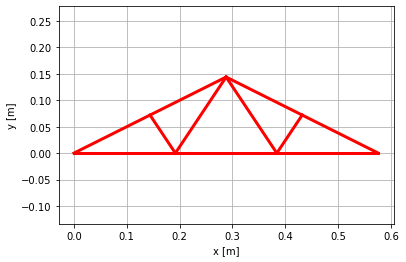

In [4]:
entradaNome = 'entrada2.xls'
nn, N, nm, Inc, nc, F, nr, R = importa(entradaNome)

print(f'Número de Nós\n{nn}\n\n')

print(f'Matriz dos Nós\n{N}\n\n')

print(f'Número de Membros\n{nm}\n\n')

print(f'Matriz de Incidência\n{Inc}\n\n')

print(f'Número de Cargas\n{nc}\n\n')

print(f'Vetor Carregamento\n{F}\n\n')

print(f'Número de Restrições\n{nr}\n\n')

print(f'Vetor com os Graus de Liberdade Restritos\n{R}\n\n')
                                                                            
plota(N,Inc)

In [5]:
# Criando os elementos presntes na treliça
elementos = []
for i in range(nm):
    x = organize_elements(i, Inc, N)
    x.print_element()
    elementos.append(x)
    print('\n')

elemento = 1
incidencia = [1 2]
l = 0.16099689437998485
A = 5.25e-06
E = 193140000000.0
c = 0.8944271909999159
s = 0.4472135954999579
stiffness_matrix = [[ 5038531.97370028  2519265.98685014 -5038531.97370028 -2519265.98685014]
 [ 2519265.98685014  1259632.99342507 -2519265.98685014 -1259632.99342507]
 [-5038531.97370028 -2519265.98685014  5038531.97370028  2519265.98685014]
 [-2519265.98685014 -1259632.99342507  2519265.98685014  1259632.99342507]]


elemento = 2
incidencia = [2 4]
l = 0.16099689437998485
A = 5.25e-06
E = 193140000000.0
c = 0.8944271909999159
s = 0.4472135954999579
stiffness_matrix = [[ 5038531.97370028  2519265.98685014 -5038531.97370028 -2519265.98685014]
 [ 2519265.98685014  1259632.99342507 -2519265.98685014 -1259632.99342507]
 [-5038531.97370028 -2519265.98685014  5038531.97370028  2519265.98685014]
 [-2519265.98685014 -1259632.99342507  2519265.98685014  1259632.99342507]]


elemento = 3
incidencia = [4 6]
l = 0.16099689437998488
A = 5.25e-06
E = 193140000000.0


In [6]:
# Criando matriz de superposição
matrix_superposition = np.zeros((nn*2, nn*2))
for elemento in elementos:
    indexes = [elemento.incidencia[0]*2-1, elemento.incidencia[0]*2, elemento.incidencia[1]*2-1, elemento.incidencia[1]*2]
    cont_line = 0
    cont_column = 0
    
    for index_line in indexes:
        for index_column in indexes:            
            matrix_superposition[index_line-1, index_column-1] += elemento.stiffness_matrix[cont_line,
                                                                                            cont_column]
            cont_column += 1
            if cont_column >= 4:
                cont_column = 0
        cont_line += 1
print('Matriz de superposição global\n', matrix_superposition)

Matriz de superposição global
 [[ 1.03197038e+07  2.51926599e+06 -5.03853197e+06 -2.51926599e+06
  -5.28117188e+06  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 2.51926599e+06  1.25963299e+06 -2.51926599e+06 -1.25963299e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.03853197e+06 -2.51926599e+06  1.36825619e+07 -3.69714935e+05
  -3.60549794e+06  5.40824691e+06 -5.03853197e+06 -2.51926599e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-2.51926599e+06 -1.25963299e+06 -3.69714935e+05  1.06316363e+07
   5.40824691e+06 -8.11237036e+06 -2.51926599e+06 -1.25963299e+06
   0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [-5.28117188e+06  0.00000000e+00 -3.

In [7]:
# Deslocamentos Nodais
restrictions = []
for i in R:
    restrictions.append(int(i[0]))

matrix_superposition_restricted = apply_restriction(matrix_superposition, restrictions, restrictions)
F_restricted = apply_restriction_1d_matrix(F, restrictions)
x = invert_matrix(matrix_superposition_restricted)
nodal_displacements = jacobi(matrix_superposition_restricted, F_restricted, 4000, 2)

values = []
for line in range(nodal_displacements.shape[0]):
    values.append(nodal_displacements[line, 0])
indexes = []
for index in range(F.shape[0]):
    if index not in restrictions:
        indexes.append(index)

nodal_displacements_extended = extend_matrix(F.shape[0], values, indexes)

In [8]:
# Deformacoes
deformations_matrix = np.zeros((len(elementos), 1))
line = 0
for elemento in elementos:
    e = deformations(elemento, nodal_displacements_extended)
    deformations_matrix[line, 0] = e
    line+=1
print('Matriz de deformações\n', deformations_matrix)

Matriz de deformações
 [[-0.00639516]
 [-0.00449315]
 [-0.00377645]
 [-0.00352836]
 [-0.00075561]
 [ 0.00075561]
 [ 0.00191125]
 [-0.00191125]
 [ 0.00187379]
 [ 0.00103552]
 [ 0.00315587]]


In [9]:
# Tensoes internas [Pa]
tensions_matrix = np.zeros((len(elementos), 1))
line = 0
for elemento in elementos:
    t = tensions(elemento, nodal_displacements_extended)
    tensions_matrix[line, 0] = t
    line+=1


In [10]:
# Forcas internas [N]
internal_forces = tensions_matrix*elemento.A


In [11]:
# Matriz de reações 
restrictions = []
for i in R:
    restrictions.append(int(i[0]))

supportive_reactions = np.dot(matrix_superposition, nodal_displacements_extended)

reactions_indexes = []
for i in range(supportive_reactions.shape[0]):
    if i not in restrictions:
        reactions_indexes.append(i)
    

In [12]:
# Gerando Saída
Ft = apply_restriction_1d_matrix(supportive_reactions, reactions_indexes)
Ut = nodal_displacements_extended
Epsi = deformations_matrix
Fi = internal_forces
Ti = tensions_matrix
geraSaida('saida',Ft,Ut,Epsi,Fi,Ti)
printSaida(Ft,Ut,Epsi,Fi,Ti)


    Reacoes de apoio [N]
    [[3900.]
 [2900.]
 [1600.]]


    Deslocamentos [m]
    [[ 0.        ]
 [ 0.        ]
 [ 0.00100474]
 [-0.00431173]
 [ 0.00035977]
 [-0.00466313]
 [ 0.00025974]
 [-0.00443928]
 [ 0.00055859]
 [-0.00463759]
 [-0.00032427]
 [-0.00424778]
 [ 0.00116451]
 [ 0.        ]]


    Deformacoes []
    [[-0.00639516]
 [-0.00449315]
 [-0.00377645]
 [-0.00352836]
 [-0.00075561]
 [ 0.00075561]
 [ 0.00191125]
 [-0.00191125]
 [ 0.00187379]
 [ 0.00103552]
 [ 0.00315587]]


    Forcas internas [N]
    [[-6484.59713475]
 [-4555.98850416]
 [-3829.26641147]
 [-3577.708764  ]
 [ -766.17964604]
 [  766.17964604]
 [ 1937.98381056]
 [-1937.98381056]
 [ 1900.        ]
 [ 1050.        ]
 [ 3200.        ]]


    Tensoes internas [Pa]
    [[-1.23516136e+09]
 [-8.67807334e+08]
 [-7.29384078e+08]
 [-6.81468336e+08]
 [-1.45938980e+08]
 [ 1.45938980e+08]
 [ 3.69139773e+08]
 [-3.69139773e+08]
 [ 3.61904762e+08]
 [ 2.00000000e+08]
 [ 6.09523810e+08]]


    


In [15]:
for i in range(internal_forces.shape[0]):
    for j in range(internal_forces.shape[1]):
        print(internal_forces[i,j])

-6484.597134749379
-4555.988504155809
-3829.2664114683766
-3577.708763999648
-766.179646036095
766.179646036095
1937.9838105618878
-1937.9838105618903
1899.9999999999843
1049.9999999999893
3199.999999999982


(-0.029091128566990632,
 0.6109136999068032,
 -0.03168142767302945,
 0.15236578227014425)

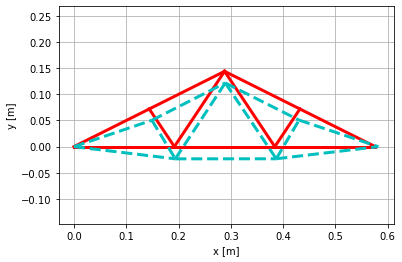

In [13]:
# Vamos ajeitar os posicionamentos dos pontos da traliça dados seus dislocamentos nodais
plota_truss(N,Inc, 'r', '', 'Treliça Inicial')

n = 0
for i in range(0, nodal_displacements_extended.shape[0], 2):
    N[0, n] += nodal_displacements_extended[i, 0]*5
    n+=1
    
n = 0
for i in range(1, nodal_displacements_extended.shape[0], 2):
    N[1, n] += nodal_displacements_extended[i, 0]*5
    n+=1
    
plota_truss(N,Inc, 'c', '--', 'Treliça pós deslocamento')
    
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(True)
plt.axis('equal')
# plt.savefig('deslocamentos_nodais.png')

C:\Users\adney\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 4 in `xvals` is outside the range of its associated line (xmin=0.14902368869259694, xmax=0.19379884317815352, xval=0.14691019926330268). Clipping it into the allowed range.
  warnings.warn(
C:\Users\adney\AppData\Local\Programs\Python\Python310\lib\site-packages\labellines\core.py:204: UserWarning: The value at position 9 in `xvals` is outside the range of its associated line (xmin=0.19379884317815352, xmax=0.3867929407239752, xval=0.530913096347579). Clipping it into the allowed range.
  warnings.warn(


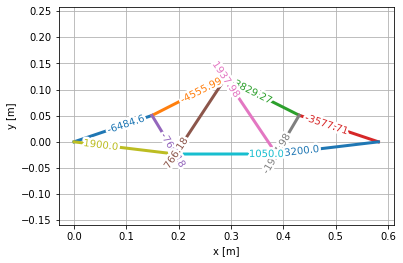

In [14]:
# plt.figure(figsize=(15,10))
plot_internal_forces(N,Inc, internal_forces)
labelLines(plt.gca().get_lines(), zorder=2.)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.grid(True)
plt.axis('equal')
plt.savefig('forcas_internas.png')